#### Jérémy TREMBLAY

# TP3 : K-means

In [1]:
# Import the libraries that will be used in this notebook.
import numpy as np
import pandas as pd

# Import the pyplot module from matplotlib with the plt alias.
import matplotlib.pyplot as plt

# Other usefull libraries (sklearn, ...)
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Task 6: Found the *k* parameter using K-average algorithm

**Consigne :** Vous allez vous baser sur la base de données country qui propose des informations relatives à certains
pays. L’objectif est de pouvoir judicieusement catégoriser ces pays à partir de leurs descripteurs.  
À partir des connaissances acquises lors de la première partie de ce TP, utilisez l’algorithme des K-moyennes pour cibler le meilleur paramètre *k* :  

* La colonne `country` sera à négliger en entrée de l’algorithme.
* Toutefois, cette colonne pourra permettre d’analyser les pays et leurs appartenances aux clusters.  

À ce stade, vous devez avoir identifier un paramètre *k* qui vous semble cohérent.

First, let's load the data.

In [2]:
# Specify the relative path of the country file.
file_path = 'datasets/country.csv'

# Load the database into a DataFrame.
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame with head.
print(df.head())

               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200  


In [3]:
print(df.isnull().any())

country       False
child_mort    False
exports       False
health        False
imports       False
income        False
inflation     False
life_expec    False
total_fer     False
gdpp          False
dtype: bool


The dataset is already clean, we can easily read it now and search some information.

In [4]:
# Know the dimensions of the dataframe.
df.shape

(167, 10)

There is 167 rows and 10 columns, let's check the content more in detail with some stats.

In [5]:
# Display usefull information about the dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [6]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


The dataset contains information about various countries and their socio-economic indicators. Each row represents a different country, and the columns provide various indicators and metrics. Let's go through the columns and what they represent:

* `country`: This column contains the name of the country.
* `child_mort`: Child mortality rate, which represents the number of deaths of children under the age of five per 1,000 live births. It is an important indicator of a country's overall health and development.
* `exports`: The percentage of a country's GDP represented by its exports. This is a measure of a country's trade activity.
* `health`: The percentage of a country's GDP spent on healthcare. It indicates the level of investment in healthcare services.
* `imports`: The percentage of a country's GDP represented by its imports. This complements the exports column and provides insights into trade balance.
* `income`: The per capita income of the country's residents, usually measured in USD. It is an indicator of the country's economic well-being.
* `inflation`: The inflation rate, which measures the increase in the general price level of goods and services. It's an important economic indicator.
* `life_expec`: Life expectancy at birth, representing the average number of years a person can expect to live. It's a key health indicator.
* `total_fer`: The total fertility rate, which represents the average number of children born to a woman during her lifetime. It is related to population growth.
* `gdpp`: Gross Domestic Product (GDP) per capita, which is the total economic output of a country divided by its population. It's a measure of a country's economic development.

In [7]:
# Let's drop the country column.
X = df.drop("country", axis=1)

# Let's use PCA.
pca = decomposition.PCA(n_components=2)
X_reshaped = pca.fit_transform(X)

Now, let's dive into the main topic: find the best *k* parameter. Let's reuse the previous function with the silhouette score to determine this value:

In [8]:
def euclidian_distance_from_centroid(X, k):
    """
    Calculate the sum of squared distances of data points from thir respective cluster centroids for different values of k.

    Parameters:
    X (array-like): Input data.
    k (int): The maximum number of cluster to consider.

    Returns:
    list: A list of errors, where each error represents the sum of squared distances for a specific number of clusters.

    The function compute the sum of squared distances for different values of k by performing K-Means clustering
    with k clusters for each value of k. It computes the squared Euclidean distance between data points and their
    assigned cluster centroids. The errors are then stored in a list for further analysis.
    """
    errors = []  # Used to stock the errors for different values for k.

    # Iterate through k values.
    for i in range(1, k + 1):
        # Create and train a model base on the k value, then get the centroids and label and compute the error.
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
        kmeans.fit(X)
        centroids = kmeans.cluster_centers_
        labels = kmeans.labels_
        error = 0
        # Compute the sum of squared distances for a specific number k number of cluster.
        for j in range(i):
            cluster_points = X[labels == j]
            error += np.sum((cluster_points - centroids[j]) ** 2)
        errors.append(error)
    return errors

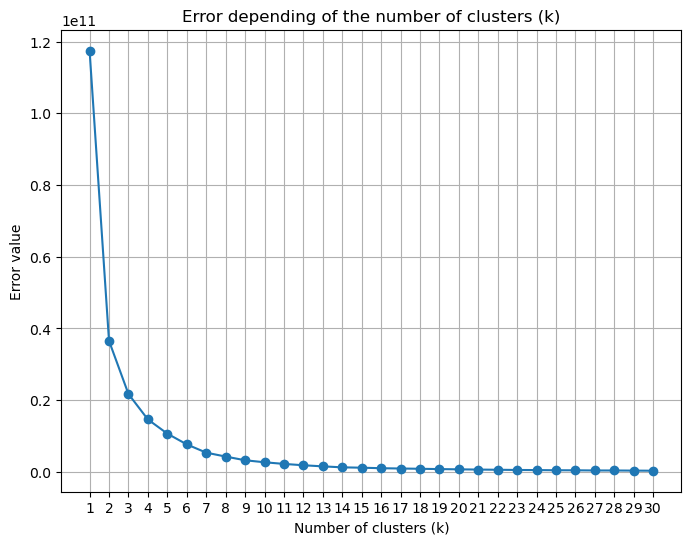

In [9]:
# Compute errors for k between 1 to 20.
kmax = 30
errors = euclidian_distance_from_centroid(X_reshaped, kmax)

# Display errors.
plt.figure(figsize=(8, 6))
plt.plot(range(0, kmax), errors, marker='o')
plt.title('Error depending of the number of clusters (k)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Error value')
plt.xticks(np.arange(kmax), np.arange(kmax) + 1)
plt.grid(True)
plt.show()

Using the information provided by this graph, we cannot truly determine an ideal parameter for *k* since we are relying on the minimum value of the error, but here, it continuously decreases over time. Even if it seems the big decrease is at *k* = 2, we cannot be sure about this information. We will need to use another criterion to find the value of *k*, and for that, we will calculate the silhouette score.

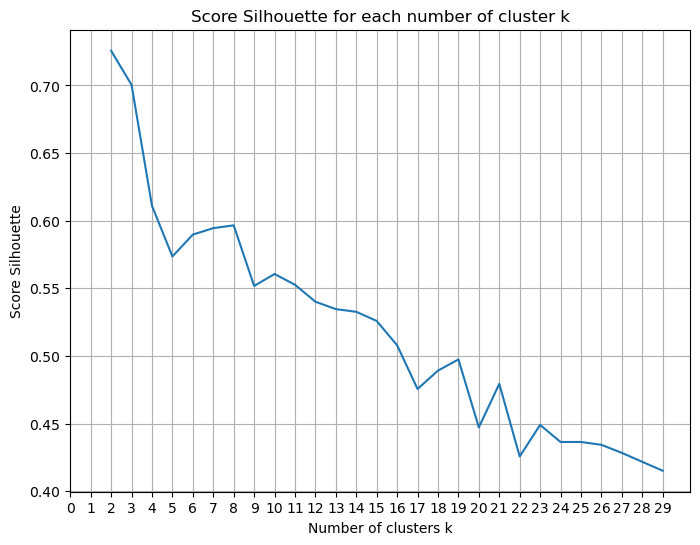

In [10]:
# Used to store data.
silhouette_scores = []

# Compute silouhette score for each k.
for k in range(2,kmax):
    # Create a model and fit it.
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_reshaped)
    labels = kmeans.labels_
    # Compute silhouette score.
    score = silhouette_score(X_reshaped, labels)
    silhouette_scores.append(score)

# Display data.
plt.figure(figsize=(8, 6))
plt.plot(range(2, kmax), silhouette_scores)
plt.title('Score Silhouette for each number of cluster k')
plt.xlabel('Number of clusters k')
plt.ylabel('Score Silhouette')
plt.xticks(np.arange(kmax), np.arange(kmax))
plt.grid(True)
plt.show()

Based on the information gathered, it is observed that the silhouette score is highest at *k* = 2. Therefore, we will choose *k* = 2 for our model.

## Task 7: Scale the program

**Consigne :** Nous avons actuellement négligé un paramètre important : la mise à l’échelle. Dans la manière de procéder, l’algorithme des K-moyennes ressemble à l’algorithme *KNN* qui lui, était sensible à cette mise à l’échelle. En effet, tous deux sont basés sur des notions de distance.  

Explorer le besoin ou non de normaliser les données pour l’algorithme des K-moyennes :  
* Il est possible d’utiliser le `StandardScaler` vu avec le *KNN*, mais aussi le `MinMaxScaler`.
* Il faudra identifier à quel niveau cette normalisation est nécessaire (avant analyse *PCA* ou post-analyse).
* Évaluer les performances du modèle avec cette mise à l’échelle.

### With StandardScaler

To test this, we will first create a function to display our two graph to easily compare data.

In [11]:
def display_graphs_k_value(kmax, X_data):

    # Compute the error using euclidian distance from centroid.
    errors = euclidian_distance_from_centroid(X_data, kmax)

    # Display errors.
    plt.figure(figsize=(8, 6))
    plt.plot(range(0, kmax), errors, marker='o')
    plt.title('Error depending of the number of clusters (k)')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Error value')
    plt.xticks(np.arange(kmax), np.arange(kmax) + 1)
    plt.grid(True)
    plt.show()

    # Compute silhouette score.

    # Used to store data.
    silhouette_scores = []

    # Compute silouhette score for each k.
    for k in range(2,kmax):
        # Create a model and fit it.
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_data)
        labels = kmeans.labels_
        # Compute silhouette score.
        score = silhouette_score(X_data, labels)
        silhouette_scores.append(score)

    # Display data.
    plt.figure(figsize=(8, 6))
    plt.plot(range(2, kmax), silhouette_scores)
    plt.title('Score Silhouette for each number of cluster k')
    plt.xlabel('Number of clusters k')
    plt.ylabel('Score Silhouette')
    plt.xticks(np.arange(kmax), np.arange(kmax))
    plt.grid(True)
    plt.show()

Now let's test the `StandardScaler` before a `PCA` decomposition:

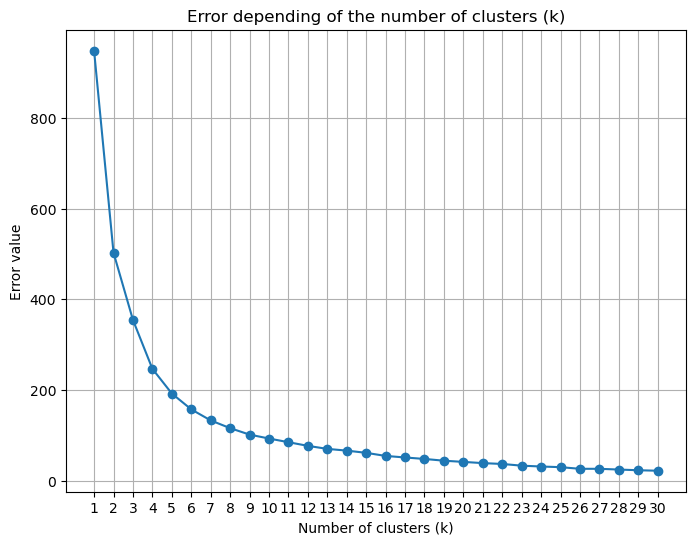

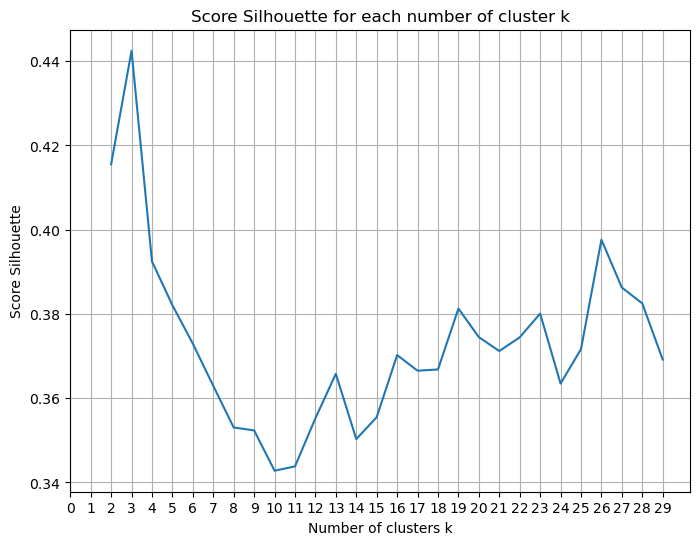

In [12]:
# Normalize the data before PCA.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_reshaped_ss_before = pca.fit_transform(X_scaled)
display_graphs_k_value(kmax=kmax, X_data=X_reshaped_ss_before)

Clearly, with normalization using `StandardScaler` before `PCA`, we get *k* = 3 as an interesting value.
Now, we will perform the same normalization but after `PCA`.

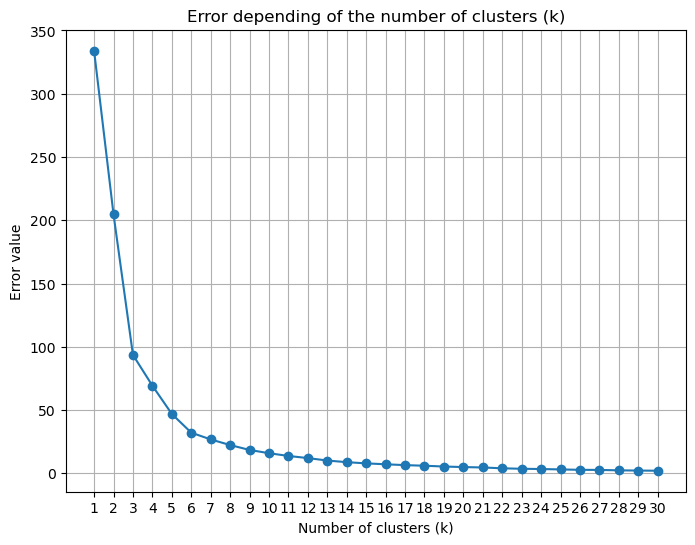

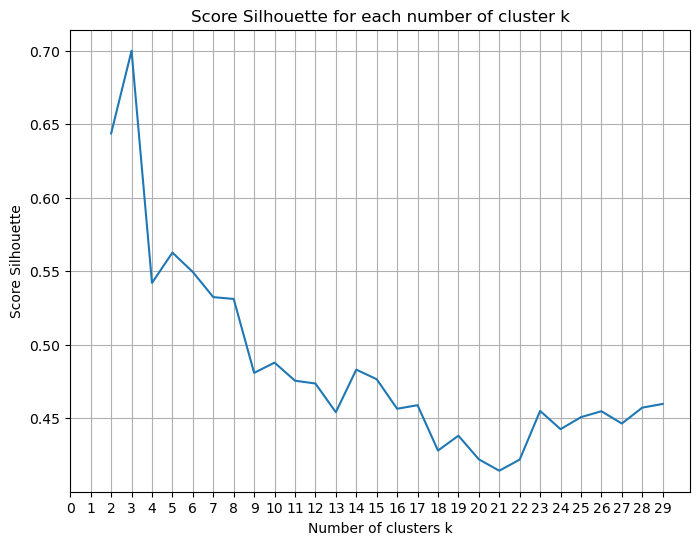

In [13]:
# Use PCA then the StandardScaler.
X_scaled = pca.fit_transform(X) 
X_reshaped_ss_after = scaler.fit_transform(X_scaled)
display_graphs_k_value(kmax=kmax, X_data=X_reshaped_ss_after)

We don't observe a significant difference between using Standard Scaler before or after `PCA`; we still find *k* = 3 as the optimal value.

### With MinMaxScaler

We apply the same process but with `MinMaxScaler`:

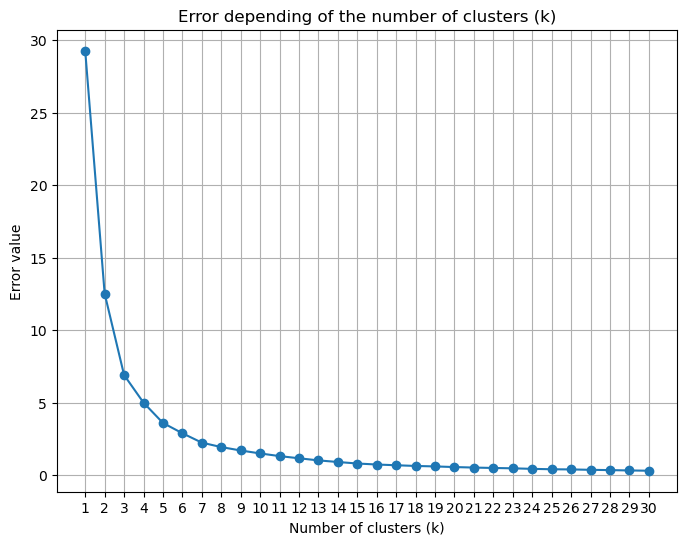

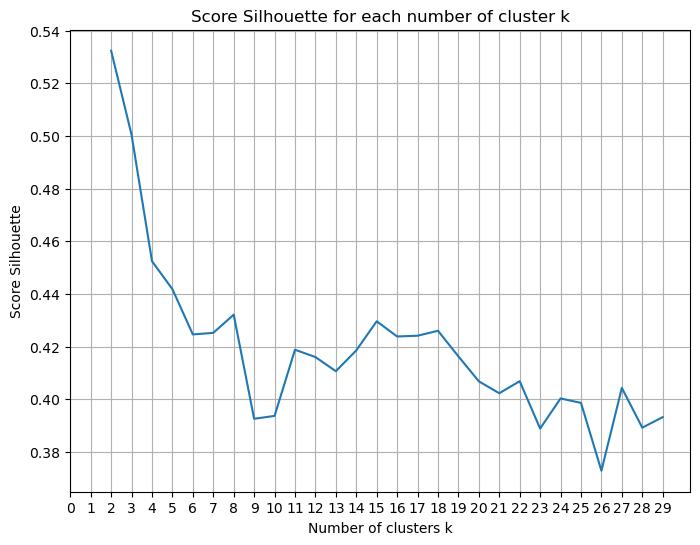

In [14]:
# Normalize the data before PCA.
min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
X_reshaped_mms_before = pca.fit_transform(X_scaled)
display_graphs_k_value(kmax=kmax, X_data=X_reshaped_mms_before)

Again, here we find *k* = 2.

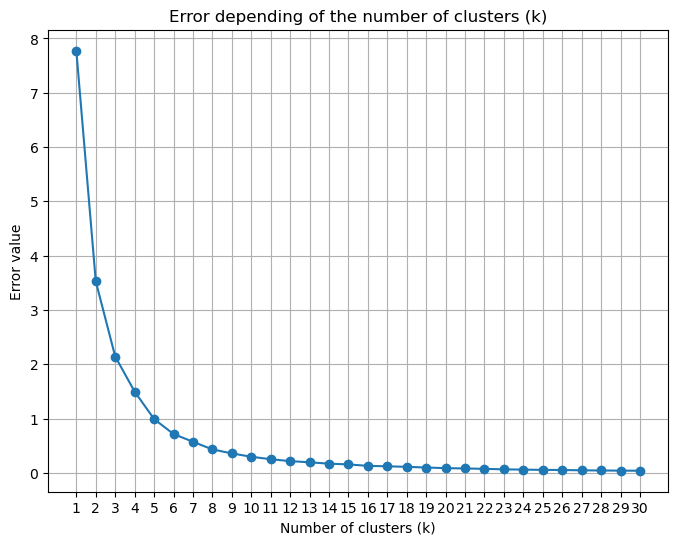

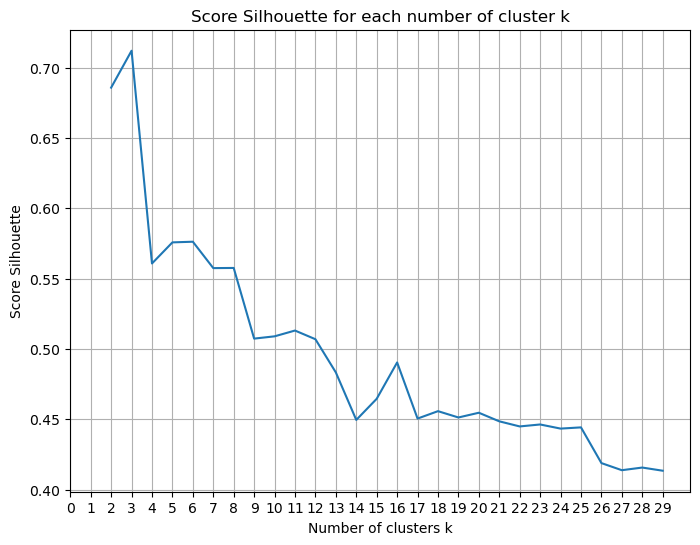

In [15]:
# Use PCA then the MinMaxScaler.
X_scaled = pca.fit_transform(X) 
X_reshaped_mms_after = min_max_scaler.fit_transform(X_scaled)
display_graphs_k_value(kmax=kmax, X_data=X_reshaped_mms_after)

**Conclusion:**  From the data, we can conclude that the use of `StandardScaler` provides a value of *k* = 3 when applied (either before or after `PCA`), and `MinMaxScaler` provides a value of *k* = 2 when used before `PCA` and *k* = 3 when used after `PCA`. The choice of scaler and its application in the preprocessing pipeline can influence the optimal number of clusters (*k*) obtained from the K-Means algorithm. Therefore, it's essential to consider the scaler choice in combination with the `PCA` and K-Means clustering to determine the most suitable *k* value for the dataset.